In [13]:
from myNoteBook.code.titanic.data_clean import NameToLength
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## exercise 1

1. 因为数据比价慢，所以训练的数据，只是用了1万个。发觉还可以，但是也要跑几分钟
2. 结果真的和数据的相关性有关，我1000的时候，准确率只有88%左右
3. 不过最后的参数是一样的看了一下他做的练习。有时候不得不说，这类东西是个玄学啊。

In [14]:

from sklearn.datasets import fetch_openml
import numpy as np


mnist = fetch_openml('mnist_784', version=1, cache=True, data_home="./../sklearn")

mnist.target = mnist.target.astype(np.int8)
mnist["data"],mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([5, 0, 4, ..., 4, 5, 6], dtype=int8))

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

X = mnist["data"]
Y = mnist["target"]

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

X_train, Y_train,X_test, Y_test = None,None,None,None
for train_index, test_index in split.split(X, Y):
    X_train = X[train_index]
    X_test = X[test_index]
    Y_train = Y[train_index]
    Y_test = Y[test_index]

"trains size is {}, test size is {}".format(len(X_train),len(X_test))

'trains size is 56000, test size is 14000'

感觉`KNeighborsClassifier`的predict很慢

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import  GridSearchCV

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,Y_train)

param_grid = [
    {
        'weights': ["uniform",'distance'],
        'n_neighbors': [3,4,5]
    }
]

e1_size = 100
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, n_jobs=-1,verbose=3,scoring='accuracy')
grid_search.fit(X_train[:e1_size], Y_train[:e1_size])

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:    1.3s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:    1.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.4s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=3)

In [17]:
grid_search.best_score_

0.6900000000000001

In [18]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [19]:
from sklearn.metrics import accuracy_score
y_pred = grid_search.predict(X_test)
accuracy_score(Y_test,y_pred)


0.6447857142857143

## exercise 2 。不做了。  
不过方式算是了解了。图像数据不够的时候，可以通过这种方式来凑数据。

## exercise3 


In [20]:
import pandas as pd

train_source = pd.read_csv("data/titanic/train.csv")
test_source = pd.read_csv("data/titanic/test.csv")

train_source['Ticket']
train_source.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

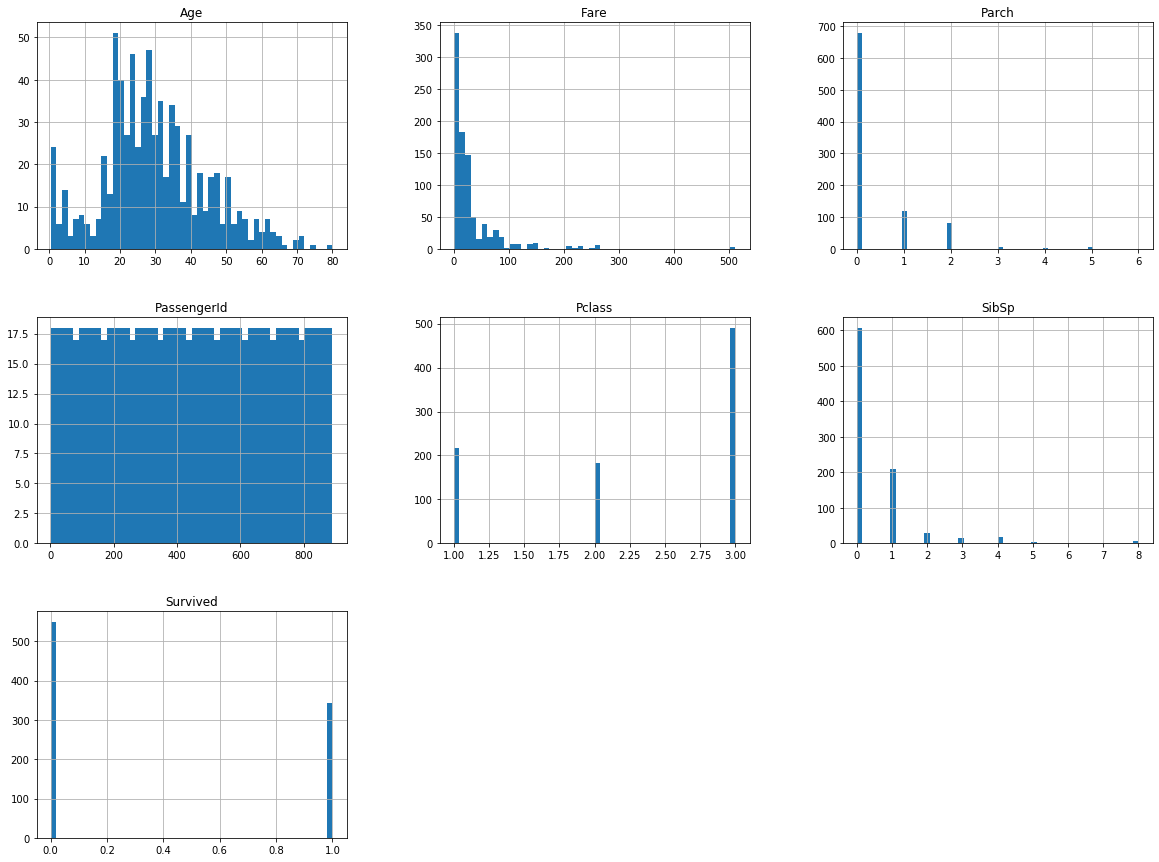

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
train_source.hist(bins=50, figsize=(20,15))
plt.show()

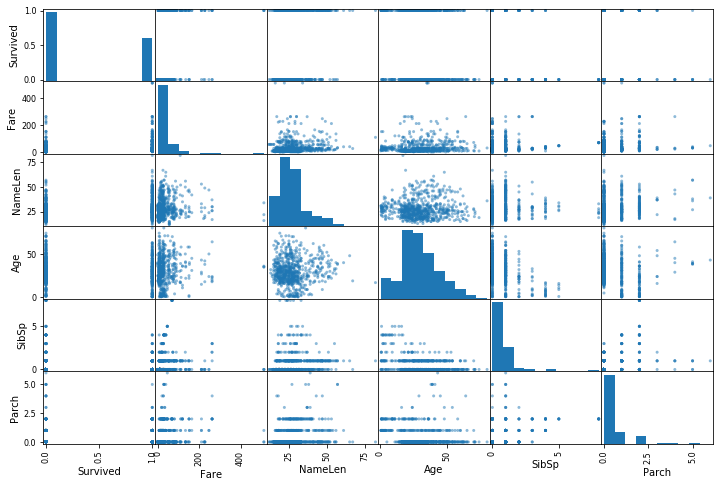

In [22]:
from pandas.plotting import scatter_matrix
column=['Survived','Fare','NameLen','Age','SibSp','Parch']
train_source['NameLen']=train_source['Name'].apply(len)
test_source['NameLen']=test_source['Name'].apply(len)
scatter_matrix(train_source[column], figsize=(12, 8))
plt.show()

In [23]:
survived = train_source['Survived']
Y_set = survived.values
Y_set.shape
train_source = train_source.drop("Survived",axis=1)


In [24]:

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ('Name',NameToLength()),
        ('imputer', SimpleImputer(strategy='median')),
        ('std', StandardScaler())
])
num_attr = ['Age','SibSp','Parch','Fare','Name']

prepare_pipeline = ColumnTransformer([
    ("num",num_pipeline,num_attr),
    ("Pclass",OneHotEncoder(sparse=False),["Pclass"]),
    ("Sex",OneHotEncoder(sparse=False),["Sex"]),
    #("Cabin",OneHotEncoder(sparse=False),["Cabin"]),
    ("Embarked",OneHotEncoder(sparse=False),["Embarked"])
])
train_source["Embarked"] = train_source["Embarked"].fillna('N')
train_source["Cabin"] = train_source["Cabin"].fillna('')
train_set = prepare_pipeline.fit_transform(train_source)
train_set.shape


(891, 14)

In [25]:
train_source.columns,test_source.columns

(Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
        'Ticket', 'Fare', 'Cabin', 'Embarked', 'NameLen'],
       dtype='object'),
 Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
        'Ticket', 'Fare', 'Cabin', 'Embarked', 'NameLen'],
       dtype='object'))

In [26]:
test_source["Embarked"] = test_source["Embarked"].fillna('N')
test_source["Cabin"] = test_source["Cabin"].fillna('')
test_set = prepare_pipeline.transform(test_source)
test_set.shape


(418, 14)

In [27]:
exe_2_knn_clf = KNeighborsClassifier()
exe_2_knn_clf.fit(train_set,Y_set)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [28]:
titantic_pred = exe_2_knn_clf.predict(test_set)
titantic_pred.shape

(418,)

In [29]:
titanic_real = pd.read_csv("data/titanic/gender_submission.csv")['Survived'].values
titanic_real.shape

(418,)

In [30]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(titanic_real,titantic_pred)
matrix


array([[241,  25],
       [ 28, 124]])

In [31]:
from sklearn.metrics import precision_score,recall_score,f1_score
precision = precision_score(titanic_real,titantic_pred)
recall= recall_score(titanic_real,titantic_pred)
f1 = f1_score(titanic_real,titantic_pred)
"precision score is {}, recall score is {}, f1 score is {}".format(precision,recall,f1)




'precision score is 0.8322147651006712, recall score is 0.8157894736842105, f1 score is 0.8239202657807309'